In [2]:
#!/usr/bin/env python3
import os, random, shutil
from glob import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm

# ─── Prevent Windows OpenMP errors ─────────────────────────────────────────────
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"]     = "1"

# ─── 1. SPLIT DATASET ──────────────────────────────────────────────────────────
def split_dataset(src_dir, train_dir, test_dir, sample_size=500, seed=42):
    for d in (train_dir, test_dir):
        if os.path.exists(d): shutil.rmtree(d)
        os.makedirs(d)
    all_sats = sorted(glob(os.path.join(src_dir, "*_sat.jpg")))
    random.seed(seed); random.shuffle(all_sats)
    samp = all_sats[:sample_size]
    n_train = int(0.7 * sample_size)
    for sats, dest in ((samp[:n_train], train_dir), (samp[n_train:], test_dir)):
        for s in sats:
            b = os.path.basename(s).replace("_sat.jpg","")
            shutil.copy(s,       os.path.join(dest, b+"_sat.jpg"))
            shutil.copy(os.path.join(src_dir, b+"_mask.png"),
                        os.path.join(dest, b+"_mask.png"))
    tb = {os.path.basename(p).split("_")[0] for p in glob(train_dir+"/*_sat.jpg")}
    vb = {os.path.basename(p).split("_")[0] for p in glob(test_dir +"/*_sat.jpg")}
    assert tb.isdisjoint(vb), "Overlap in splits!"
    print(f"Split: {n_train} train, {sample_size-n_train} test")

# ─── 2. DATASET ─────────────────────────────────────────────────────────────────
class RoadDataset(Dataset):
    def __init__(self, img_paths, mask_paths, size=256):
        self.img_paths, self.mask_paths = img_paths, mask_paths
        self.tf = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, i):
        img = Image.open(self.img_paths[i]).convert("RGB"); img = self.tf(img)
        m   = Image.open(self.mask_paths[i]).convert("L")
        m   = m.resize(self.tf.transforms[0].size, Image.NEAREST)
        arr = (np.array(m)>128).astype(np.float32)
        return img, torch.from_numpy(arr)[None]

# ─── 3. ARCHITECTURE ─────────────────────────────────────────────────────────────

class ResidualConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch,3,padding=1,bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch,out_ch,3,padding=1,bias=False),
            nn.BatchNorm2d(out_ch))
        self.skip  = nn.Conv2d(in_ch,out_ch,1,bias=False) if in_ch!=out_ch else nn.Identity()
        self.relu  = nn.ReLU(inplace=True)
    def forward(self,x):
        out = self.conv1(x); out = self.conv2(out)
        return self.relu(out + self.skip(x))

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        rates = [1,6,12,18]
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=r, dilation=r, bias=False),
                nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
            ) for r in rates
        ])
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
        self.project = nn.Sequential(
            nn.Conv2d(out_ch*(len(rates)+1), out_ch,1,bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )
    def forward(self,x):
        res = [b(x) for b in self.branches]
        gp  = self.global_pool(x)
        gp  = F.interpolate(gp, size=x.shape[2:], mode='bilinear',align_corners=False)
        res.append(gp)
        return self.project(torch.cat(res,1))

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int,1,bias=False), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int,1,bias=False), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int,1,1,bias=False), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu= nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        g1 = F.interpolate(g1, size=x.shape[2:], mode='bilinear',align_corners=False)
        x1 = self.W_x(x)
        psi= self.relu(g1 + x1)
        psi= self.psi(psi)
        return x * psi

class UpConv(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up  = nn.ConvTranspose2d(in_ch, out_ch,2,stride=2)
        self.res = ResidualConv(out_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:]!=skip.shape[2:]:
            x = F.interpolate(x, skip.shape[2:], mode='bilinear',align_corners=False)
        return self.res(torch.cat([skip,x],1))

class UNetWithASPP(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        # Encoder
        self.enc1 = ResidualConv(in_ch,  32)
        self.enc2 = ResidualConv(32,     64)
        self.enc3 = ResidualConv(64,    128)
        self.enc4 = ResidualConv(128,   256)
        self.pool = nn.MaxPool2d(2,2)
        # Bottleneck + ASPP
        self.center = ResidualConv(256,512)
        self.aspp   = ASPP(512,256)
        # Decoder (use in_ch=aspp_ch, skip_ch=enc_ch, out_ch)
        self.att4 = AttentionGate(256,256,128); self.up4 = UpConv(256,256,256)
        self.att3 = AttentionGate(256,128, 64); self.up3 = UpConv(256,128,128)
        self.att2 = AttentionGate(128,64,  32); self.up2 = UpConv(128,64,  64)
        self.att1 = AttentionGate(64, 32,  16); self.up1 = UpConv(64, 32,  32)
        self.final= nn.Conv2d(32, out_ch,1)

    def forward(self,x):
        c1 = self.enc1(x); p1=self.pool(c1)
        c2 = self.enc2(p1); p2=self.pool(c2)
        c3 = self.enc3(p2); p3=self.pool(c3)
        c4 = self.enc4(p3); p4=self.pool(c4)
        b  = self.center(p4); a=self.aspp(b)
        g4 = self.att4(a,c4); d4=self.up4(a,  c4)
        g3 = self.att3(d4,c3); d3=self.up3(d4, c3)
        g2 = self.att2(d3,c2); d2=self.up2(d3, c2)
        g1 = self.att1(d2,c1); d1=self.up1(d2, c1)
        return self.final(d1)

# ─── 4. LOSS & METRICS ──────────────────────────────────────────────────────────
def tversky_loss(logits, masks, α=0.7, β=0.3, smooth=1e-6):
    P  = torch.sigmoid(logits)
    TP = (P*masks).sum((1,2,3))
    FP = (P*(1-masks)).sum((1,2,3))
    FN = ((1-P)*masks).sum((1,2,3))
    T  = (TP+smooth)/(TP+α*FP+β*FN+smooth)
    return (1-T).mean()

def loss_fn(logits, masks):
    return nn.BCEWithLogitsLoss()(logits,masks) + tversky_loss(logits,masks)

def iou_score(logits, masks, thresh=0.5):
    pred = (torch.sigmoid(logits)>thresh).float()
    I = (pred*masks).sum((1,2,3))
    U = pred.sum((1,2,3))+masks.sum((1,2,3))-I
    return (I/(U+1e-6)).mean().item()

# ─── 5. TRAIN & VALIDATE ─────────────────────────────────────────────────────────
def train_epoch(model, loader, opt, device, ep, E):
    model.train(); total=0
    prog = tqdm(loader, desc=f"Train {ep}/{E}", leave=False)
    for imgs,masks in prog:
        imgs,masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        loss   = loss_fn(logits,masks)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
        prog.set_postfix(loss=total/(prog.n+1))
    return total/len(loader)

def validate(model, loader, device, ep, E):
    model.eval(); total=0
    prog = tqdm(loader, desc=f"Val   {ep}/{E}", leave=False)
    with torch.no_grad():
        for imgs,masks in prog:
            imgs,masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            total += iou_score(logits,masks)
            prog.set_postfix(IoU=total/(prog.n+1))
    return total/len(loader)


# ─── 6. VISUALIZE ───────────────────────────────────────────────────────────────
def visualize(model, ds, device, n=4):
    model.eval(); idxs=random.sample(range(len(ds)),n)
    fig,axs=plt.subplots(n,3,figsize=(12,4*n))
    with torch.no_grad():
        for i,idx in enumerate(idxs):
            img,mask = ds[idx]
            logit    = model(img.unsqueeze(0).to(device))
            pred     = (torch.sigmoid(logit)>0.5).cpu()[0,0]
            img_np   = img.permute(1,2,0).cpu().numpy()
            img_np   = np.clip(img_np* [0.229,0.224,0.225]+[0.485,0.456,0.406],0,1)
            axs[i,0].imshow(img_np);      axs[i,0].axis('off'); axs[i,0].set_title("Input")
            axs[i,1].imshow(mask[0],cmap='gray'); axs[i,1].axis('off'); axs[i,1].set_title("True Mask")
            axs[i,2].imshow(pred,cmap='gray');    axs[i,2].axis('off'); axs[i,2].set_title("Predicted Mask")
    plt.tight_layout(); plt.show()


Split: 4358 train, 1868 test


Epoch 01  train_loss: 0.9261  test_IoU: 0.3050


Epoch 02  train_loss: 0.6306  test_IoU: 0.3897


Epoch 03  train_loss: 0.5613  test_IoU: 0.4284


Epoch 04  train_loss: 0.5229  test_IoU: 0.4301


Epoch 05  train_loss: 0.4961  test_IoU: 0.4538


Epoch 06  train_loss: 0.4720  test_IoU: 0.4739


Epoch 07  train_loss: 0.4575  test_IoU: 0.4861


Epoch 08  train_loss: 0.4396  test_IoU: 0.4974


Epoch 09  train_loss: 0.4258  test_IoU: 0.4967


Epoch 10  train_loss: 0.4137  test_IoU: 0.5091


Epoch 11  train_loss: 0.4006  test_IoU: 0.5013


Epoch 12  train_loss: 0.3864  test_IoU: 0.4584


Epoch 13  train_loss: 0.3768  test_IoU: 0.5216


Epoch 14  train_loss: 0.3632  test_IoU: 0.5210


Epoch 15  train_loss: 0.3555  test_IoU: 0.5238


Epoch 16  train_loss: 0.3434  test_IoU: 0.5259


Epoch 17  train_loss: 0.3331  test_IoU: 0.5131


Epoch 18  train_loss: 0.3234  test_IoU: 0.4995


Epoch 19  train_loss: 0.3152  test_IoU: 0.5200


Epoch 20  train_loss: 0.3028  test_IoU: 0.5168


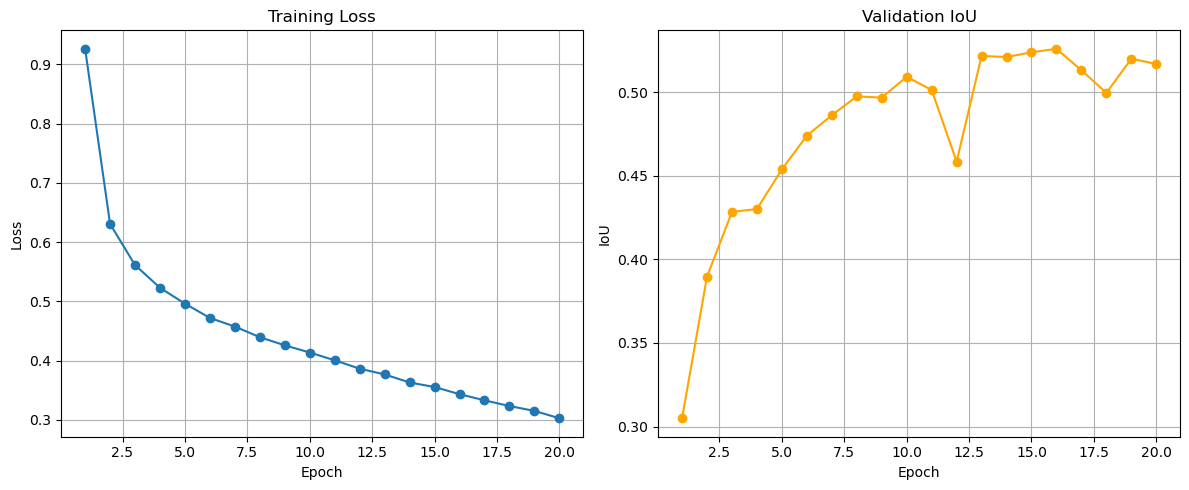

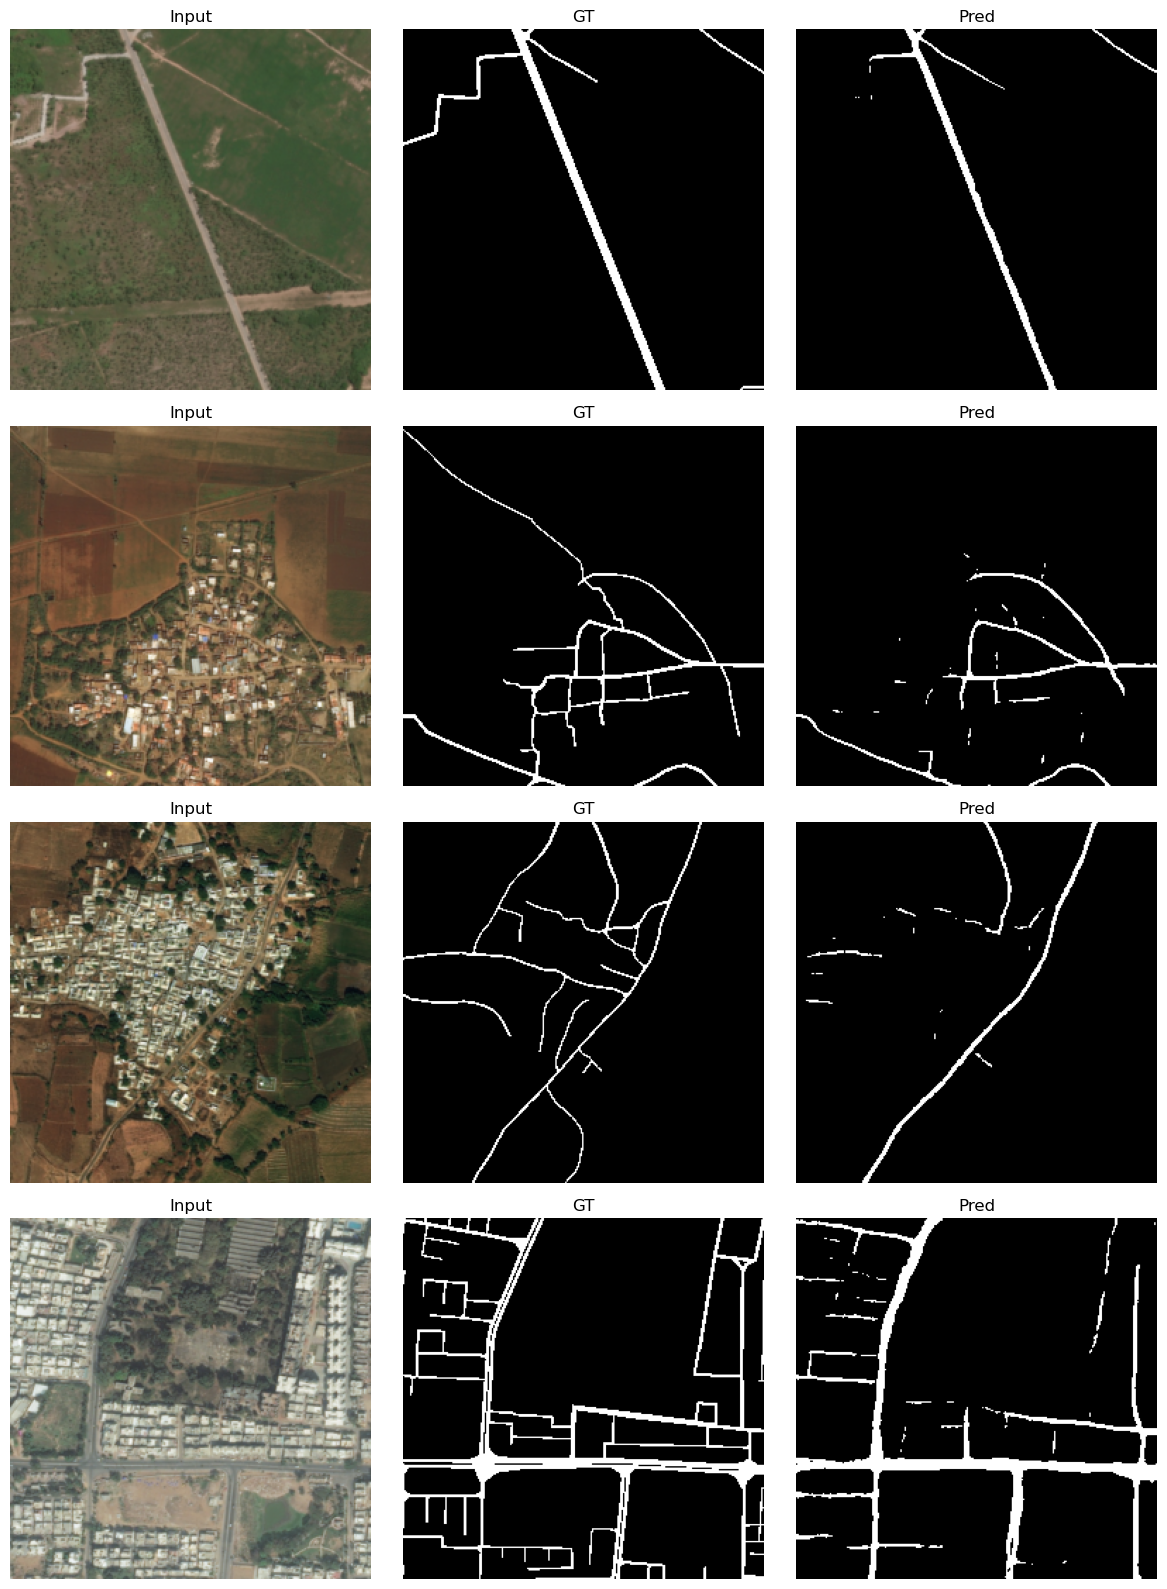

In [3]:
# ─── 7. MAIN ───────────────────────────────────────────────────────────────────
if __name__=="__main__":
    SRC, TR, TE = "./data/train", "./data/train_split", "./data/test_split"
    EPOCHS, SAMPLE = 20, 6226

    split_dataset(SRC, TR, TE, sample_size=SAMPLE, seed=42)

    train_s = sorted(glob(TR + "/*_sat.jpg"))
    train_m = [p.replace("_sat.jpg","_mask.png") for p in train_s]
    test_s  = sorted(glob(TE + "/*_sat.jpg"))
    test_m  = [p.replace("_sat.jpg","_mask.png") for p in test_s]

    train_ds = RoadDataset(train_s, train_m, size=256)
    test_ds  = RoadDataset(test_s, test_m,  size=256)
    train_ld = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
    test_ld  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = UNetWithASPP(3,1).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_ious = [], []
    best_iou = 0.0

    for ep in range(1, EPOCHS+1):
        trl = train_epoch(model, train_ld, opt, device, ep, EPOCHS)
        vio = validate(model, test_ld,   device, ep, EPOCHS)
        train_losses.append(trl)
        val_ious.append(vio)
        print(f"Epoch {ep:02d}  train_loss: {trl:.4f}  test_IoU: {vio:.4f}")
        if vio>best_iou:
            best_iou=vio
            torch.save(model.state_dict(),"best_aspp_unet.pth")

    # ─── Plot Loss & IoU ─────────────────────────────────────────────────────────
    epochs = list(range(1, EPOCHS+1))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, marker='o'); plt.title("Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, val_ious, marker='o', color='orange'); plt.title("Validation IoU")
    plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.grid(True)
    plt.tight_layout(); plt.show()

    # ─── Final visualization (reuse your visualize function) ────────────────────
    model.load_state_dict(torch.load("best_aspp_unet.pth",map_location=device))
    visualize(model, test_ds, device, n=4)


Split: 4358 train, 1868 test


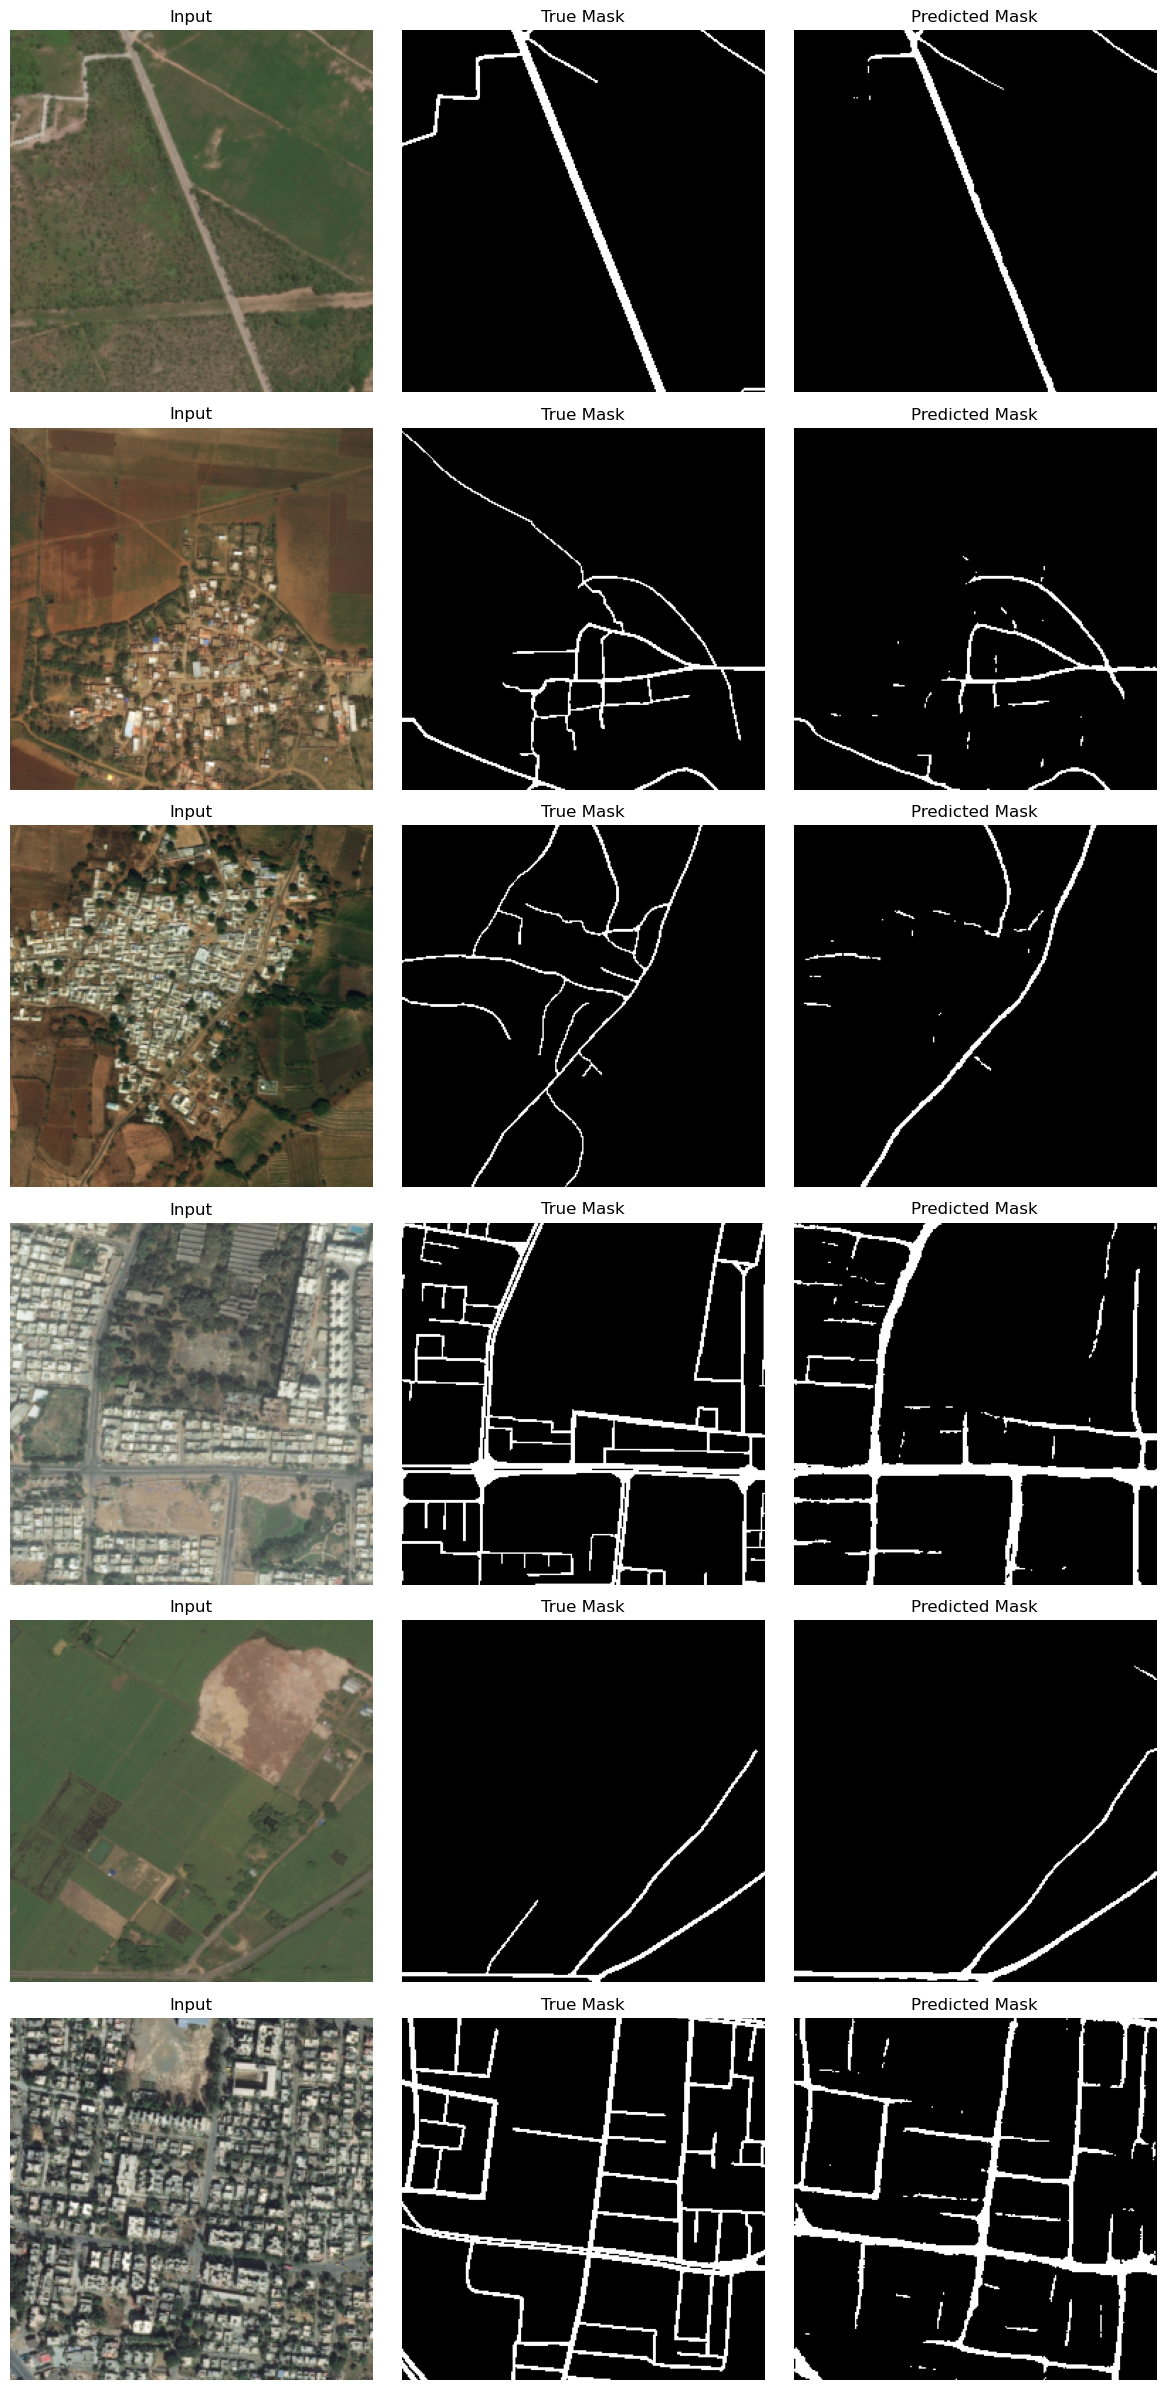

In [8]:
SRC, TR, TE = "./data/train", "./data/train_split", "./data/test_split"
EPOCHS, SAMPLE = 20, 6226

split_dataset(SRC, TR, TE, sample_size=SAMPLE, seed=42)

train_s = sorted(glob(TR + "/*_sat.jpg"))
train_m = [p.replace("_sat.jpg","_mask.png") for p in train_s]
test_s  = sorted(glob(TE + "/*_sat.jpg"))
test_m  = [p.replace("_sat.jpg","_mask.png") for p in test_s]

train_ds = RoadDataset(train_s, train_m, size=256)
test_ds  = RoadDataset(test_s, test_m,  size=256)
train_ld = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
test_ld  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0)

# ─── Final visualization (reuse your visualize function) ────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = UNetWithASPP(3,1).to(device)
model.load_state_dict(torch.load("best_aspp_unet.pth",map_location=device))
visualize(model, test_ds, device, n=6)